## Analyze A/B Test Results

A/B tests are very commonly performed by data analysts and data scientists. In this analysis, we will try to make a decision, but not only based on A/B testing. We will also make use of the old fashioned probability calculations and regression models.

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusions](#conclusions)


<a id='intro'></a>
### Introduction


For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  Our goal is to work through the dataset to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
%matplotlib inline
random.seed(42)

`1.` We will start by reading in the `ab_data.csv` data and storing it in `df`.

a. We will now start the data wrangling process and make sure of our data types and whether there are any null values.

In [2]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.dtypes

user_id          int64
timestamp       object
group           object
landing_page    object
converted        int64
dtype: object

We will convert the `timestamp` column data type to `datetime` format so we can use it afterwards as a time.

In [4]:
df['timestamp']= pd.to_datetime(df['timestamp'])
df.dtypes

user_id                  int64
timestamp       datetime64[ns]
group                   object
landing_page            object
converted                int64
dtype: object

b. What are the number of rows in the dataset ?

In [5]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [6]:
df['user_id'].nunique()

290584

Are there any null values ?

In [7]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

There are no null values. But, some `user_id`s are repeated, we will check this later if our data cleaning process.

d. The proportion of users converted.

In [8]:
df[df['converted']==1].user_id.nunique()/df.user_id.nunique()

0.12104245244060237

e. The number of times the `landing_page` and `group` don't line up.

In [9]:
df[(df['group']=='treatment') & (df['landing_page']=='old_page')].shape[0]+df[(df['group']=='control') & (df['landing_page']=='new_page')].shape[0]

3893

f. Do any of the rows have missing values?

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       294478 non-null  int64         
 1   timestamp     294478 non-null  datetime64[ns]
 2   group         294478 non-null  object        
 3   landing_page  294478 non-null  object        
 4   converted     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


It is clear that there are no missing values in our dataset. This is good news.

`2.` In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old webpage.

In such case, it is better if we can `drop` these rows so we that we only use rows we are sure of in our analysis.

In [11]:
df2 = df.drop(df[(df['group']=='treatment') &(df['landing_page']=='old_page')].index)
df2=df2.drop(df2[(df2['group']=='control') & (df2['landing_page']=='new_page')].index)
df2.shape

(290585, 5)

In [12]:
# Double Check all of the correct rows were removed - this should be (0,0)
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0] , df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) == False].shape[0]

(0, 0)

`3.` Next up, we should check if any **user_id**s are still repeated in our dataset.

a. How many unique **user_id**s are in **df2**?

In [13]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [14]:
df2.loc[df2['user_id'].duplicated(), :]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [15]:
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Since, the repeated user in both cases has the same `group`, `landing_page` and has not `converted`, we can simply just drop any of the two rows.

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [16]:
df2=df2.drop(2893)
df2.shape

(290584, 5)

`4.` We now have a **clean** dataset. We can finally start by calculating some probabilities.

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
df2[df2['converted']==1].count()[0]/df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
cont_prob=df2[(df2['converted']==1) & (df2['group']=='control')].count()[0]/df2[df2['group']=='control'].shape[0]
cont_prob

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
exp_prob=df2[(df2['converted']==1) & (df2['group']=='treatment')].count()[0]/df2[df2['group']=='treatment'].shape[0]
exp_prob

0.11880806551510564

In [20]:
obs_diff = exp_prob-cont_prob
obs_diff

-0.0015782389853555567

In [21]:
total_prob=df2[df2['converted']==1].count()[0]/df2.shape[0]
total_prob

0.11959708724499628

d. What is the probability that an individual received the new page?

In [22]:
df2[df2['landing_page']=='new_page'].count()[0]/df2.shape[0]

0.5000619442226688

Based on the data above, it is clear that the `control_group` which received the `old_page` had a slightly higher **12.04%** conversion ration that the `treatment_group` which received the `new_page`.

We are sure that the our dataset was divided equally between both `landing_page`s.


>*Let us stop and ponder for a moment.*
>
>The analysis above would have been sufficient if this was the entire population.
But, of course, this trial was only run for a few weeks, so only a **sample** has visit the old or new pages.
>
>How would be sure if the results from the calculations above will stand for a larger **sample** ? Or the whole **population** ??
>
>This is the role for part 2, the **A/B test**.

<a id='ab_test'></a>
### Part II - A/B Test


In [23]:
print("Starting time for the experiment is {}.".format(df2['timestamp'].max()))
print("Ending time for the experiment is {}.".format(df2['timestamp'].min()))
print("Experiment duration is {}".format(df2['timestamp'].max()-df2['timestamp'].min()))

Starting time for the experiment is 2017-01-24 13:41:54.460509.
Ending time for the experiment is 2017-01-02 13:42:05.378582.
Experiment duration is 21 days 23:59:49.081927


However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.

>Without any clear data about the type of services or products provided by the website, we cannot decide for sure if the 3 weeks period is sufficient to deduce any data.<br>
>If this website was for example selling **groceries**, then three weeks would be enough since people can visit the website at least once a week.<br>
>If this was a **clothing store**, then maybe the 3-week period is not sufficient.


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$H_0: p_{old} \geq p_{new}$

$H_1: p_{old} < p_{new}$


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br>
We will use a sample size for each page equal to the ones in **ab_data.csv**.  <br>
We will then perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [24]:
p_new=total_prob
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [25]:
p_old=total_prob
p_old

0.11959708724499628

c. What is $n_{new}$?

In [26]:
n_new=df2[df2['group']=='treatment'].shape[0]
n_new

145310

d. What is $n_{old}$?

In [27]:
n_old=df2[df2['group']=='control'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [28]:
new_page_converted = np.random.choice([1,0], size=n_new, p=[p_new,1-p_new])
new_page_converted.mean()

0.11898699332461633

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [29]:
old_page_converted = np.random.choice([1,0], size=n_old, p=[p_old,1-p_old])
old_page_converted.mean()

0.11942949185676721

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [30]:
sample_diff = new_page_converted.mean() - old_page_converted.mean()
sample_diff

-0.0004424985321508784

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [31]:
#new_page_converted = np.random.binomial(n_new, p_new, 10000)/n_new
#old_page_converted = np.random.binomial(n_old, p_old, 10000)/n_old
#p_diffs = new_page_converted - old_page_converted 

p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([1,0], size=n_new, p=[p_new,1-p_new])
    old_page_converted = np.random.choice([1,0], size=n_old, p=[p_old,1-p_old])
    diff_conv_prob = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(diff_conv_prob)

i. Plot a histogram of the **p_diffs**.

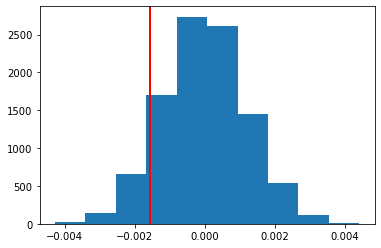

In [32]:
plt.hist(p_diffs);
plt.axvline(obs_diff,color='r', linewidth=2);

The normal distibution is expected due to the **Central Limit Theorem**.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [33]:
(p_diffs>obs_diff).mean()

0.9045

*If P is high, the null will fly.*

We **fail to reject** the null hypothesis.

This means that there is no enough evidence to accept that the new webpage increases the conversion.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance.

In [34]:
import statsmodels.api as sm

convert_old = df2[(df2['converted']==1) & (df2['group']=='control')].count()[0]
convert_new = df2[(df2['converted']==1) & (df2['group']=='treatment')].count()[0]
nobs_array = np.array([n_new, n_old])
count_array= np.array([convert_new, convert_old])

m. Now we will use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if we defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if we defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if we defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

In [35]:
from statsmodels.stats.proportion import proportions_ztest
stat, pval = proportions_ztest(count_array, nobs_array, alternative='larger')
print('Test statistic (Z-Score) is equal to {0:0.3f}'.format(stat))
print('P-Value is equal to {0:0.3f}'.format(pval))

Test statistic (Z-Score) is equal to -1.311
P-Value is equal to 0.905


Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

For a right-tailed test, reject null if $|Z_{score}|$ > $Z_{\alpha}$. <br>

Since in our case $|Z_{score}|$ = 1.311 and $Z_{\alpha}$=1.645, we **fail to reject** the null hypothesis.

>**Comment on Z-Score**
>
>A z-score, or z-statistic, is a number representing how many standard deviations above or below the mean population the score derived from a z-test is. Essentially, it is a numerical measurement that describes a value's relationship to the mean of a group of values. If a z-score is 0, it indicates that the data point's score is identical to the mean score. A z-score of 1.0 would indicate a value that is one standard deviation from the mean. Z-scores may be positive or negative, with a positive value indicating the score is above the mean and a negative score indicating it is below the mean.<br>
*Note that a negative z-score is in line with the negative value found in the difference of means found in the manual method*

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result you acheived in the previous A/B test can also be acheived by performing a regression model.<br><br>

a. Since each row is either a conversion or no conversion, we should be performing a **logistic regression**.

b. The goal is to use **statsmodels** to fit the regression model  specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, we first need to create a column for the intercept, and create a dummy variable column for which page each user received.  We will add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [36]:
df_test=df2.copy()
df_test['intercept']=1
df_test[['control','treatment']]=pd.get_dummies(df_test['group'])
df_test['ab_page']=df_test['treatment']
df_test.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,treatment,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,0


c. We will now use **statsmodels** to import the regression model.  We will instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [37]:
log_reg=sm.Logit(df_test['converted'], df_test[['intercept','ab_page']]).fit()
log_reg.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-03-07 14:52 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

Hypothesis testing is not the same as regression models. So it would not be easy to just define a null hypothesis and an alternative one.<br>
But we can say that we are building a model correlating the landing page to the conversion probability.<br>
Another difference between hypothesis testing and regression models is tha regression models are considered as *two-tailed tests* unlike this specific hypothesis testing where the alternative hypothesis made it a one-tailed test.<br>
We have used the new page as a basis for the model since its value in the `ab_page` column is equal to 1.

The results are a bit surprising. It seems that from this test the landing page is **statistically irrelevant** since it p-value is above 0.05.<br>
But, we can at least see that holding all other variables constant, landing on the old page increases the probability of conversion by 1.015 times.<br>
This is **in line** with the results of the A/B hypothesis test done above.<br>
The cofidence interval (and also the standard error) makes us 95% confident that landing on the new page gives on average 96.3 to 100.8% more odds of buying from the website than the old page.<br>
For the intercept, we can know that the probability of converting while visiting the old page is 0.12.

For more data about the calculations above, please check the following [link](https://quantifyinghealth.com/interpret-logistic-regression-coefficients/#:~:text=If%20the%20intercept%20has%20a,outcome%20will%20be%20exactly%200.5.)

f. Now, we are considering other things that might influence whether or not an individual converts.

Is it a good idea to consider other factors to add into the regression model.  Are there any disadvantages to adding additional terms into your regression model?

This is a hard question to answer.

**From one side**, adding other factors is useful in increasing the strength of the model.<br>
**From the other side**, adding redundant (or inter-correlated) factors will weaken the model and may cause a failure of the model as a whole.

So we should pay attention before adding a new factors.

g. Now along with testing if the conversion rate changes for different pages, we will also add an effect based on which country a user lives. 

Below is the description of the data in the countries dataframe, there are a total of 2 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|country|country of user|`['US', 'UK', 'CA']`|

</center>

Merging both datasets is needed for the analysis below.


In [38]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted
user_id,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0


Let's confirm how many countries are included in the dataset.

In [39]:
df_new['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [40]:
df_new[['CA','UK','US']]=pd.get_dummies(df_new['country'])
df_new['intercept']=1
df_new.head()

,country,timestamp,group,landing_page,converted,CA,UK,US,intercept
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,0,1


In [41]:
log_reg_2=sm.Logit(df_new['converted'], df_new[['intercept','US','CA']]).fit()
log_reg_2.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.8333
Date:               2022-03-07 14:52 BIC:              212812.5723
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.19835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9868    0.0114  -174.1736  0.0000  -2.0092  -1.9645
US           -0.0099    0.0133    -0.7458  0.4558  -0.0360   0.0161
CA           -0.0507    0.0284    -1.7863  0.0740  -0.1064   0.0049
==================================================================

"""

It seems that visitors from the UK have a higher probability of conversion than other countries, 101% and 105% more than USA and Canada respectively.<br>
Maybe, the company should increase the **stocks** in UK, and maybe increase their **marketing** efforts in Canada and USA.<br>
However, from the P-value of usa, we can see that this result is **statistically irrelevant**.

How about we now include **both** the country and the landing page in the logistic regression model ?

In [42]:
df_new[['control','treatment']]=pd.get_dummies(df_new['group'])
df_new['ab_page']=df_new['treatment']
df_new.head()

,country,timestamp,group,landing_page,converted,CA,UK,US,intercept,control,treatment,ab_page
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,1,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,0,1,1,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,0,1,0,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,1,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,0,1,0,1,1


In [43]:
### Fit Your Linear Model And Obtain the Results

log_reg_3=sm.Logit(df_new['converted'], df_new[['intercept','US','CA','ab_page']]).fit()
log_reg_3.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2022-03-07 14:52 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9794    0.0127  -155.4145  0.0000  -2.0044  -1.9544
US           -0.0099    0.0133    -0.7433  0.4573  -0.0359   0.0162
CA           -0.0506    0.0284    -1.7835  0.0745  -0.1063   0.0050
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
==================================================================

"""

No new information were discovered from this regression model.
But at least know we can see effect of all available inpedendant variables `country` and `landing page` on our dependant variable, **conversion**.


How about, just as a test, we make sure that there no multicollinearity in our model ?
We are using this [link](https://medium.com/analytics-vidhya/a-practical-guide-to-logistic-regression-in-python-for-beginners-f04cf6b63d33#:~:text=B.&text=To%20check%20for%20multi%2Dcollinearity%20in%20the%20independent%20variables%2C%20the,in%20the%20logistic%20regression%20model.) to perform the test below.

In [44]:
#calculate Variance Inflation Factor
X = df_new.loc[:, ['UK','US','intercept','ab_page']]
X.head()
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_scores = pd.DataFrame() 
vif_scores["Attribute"] = X.columns 
  

vif_scores["VIF Scores"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))] 
  
display(vif_scores)

,Attribute,VIF Scores
0,UK,4.502236
1,US,4.502223
2,intercept,21.055923
3,ab_page,1.000006


This is okay.
The high VIF for the intercept can be neglected as per this [link](https://stackoverflow.com/questions/59694427/what-does-the-high-vif-for-the-constant-term-intercept-indicate#:~:text=A%20large%20vif%20in%20the,but%20only%20a%20small%20variance.)

Another thing we can do is including in our analysis higher order terms by including the interaction between the `country` and the `landing_page`.

In [45]:
df_new['US_new'] = df_new['US'] * df_new['ab_page']
df_new['CA_new'] = df_new['CA'] * df_new['ab_page']
df_new['UK_new'] = df_new['UK'] * df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,CA,UK,US,intercept,control,treatment,ab_page,US_new,CA_new,UK_new
user_id,,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,1,0,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,0,0,1,1,0,1,1,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,0,1,0,1,0,1,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,0,1,1,0,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,0,1,0,1,0,1,1,0,0,1


In [46]:
log_reg_4=sm.Logit(df_new['converted'], df_new[['intercept','US','CA','ab_page','US_new','CA_new']]).fit()
log_reg_4.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2022-03-07 14:52 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9922    0.0161  -123.4571  0.0000  -2.0238  -1.9606
US            0.0057    0.0188     0.3057  0.7598  -0.0311   0.0426
CA           -0.0118    0.0398    -0.2957  0.7674  -0.0899   0.0663
ab_page       0.0108    0.0228     0.4749  0.6349  -0.0339   0.0555
US_new       -0.0314    0.0266    -1.1807  0.2377  -0.0835   0.0207
CA_new       -0.0783    0.0568    -1.3783  0.1681  -0.1896   0.0330
==================================================================

"""

We can see only a small change in our analysis. The `US` coefficient is now positive.<br>
But this is understandable if we take a look at the confidence interval.<br>
The important question now is:<br>
By including both `countries` and `landing_page`; and the interaction, did we include any **multicollinearity** in our model ?

In [47]:
X = df_new.loc[:, ['CA','US','intercept','ab_page','US_new','CA_new']]
X.head()
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_scores = pd.DataFrame() 
vif_scores["Attribute"] = X.columns 
  

vif_scores["VIF Scores"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))] 
  
display(vif_scores)

,Attribute,VIF Scores
0,CA,2.292669
1,US,2.275077
2,intercept,7.991859
3,ab_page,4.009985
4,US_new,4.952194
5,CA_new,2.356582


It is surprising that there no collinearity in the model after the new columns, but this deems the results **acceptable**.

Let's try to check something.<br>
If a user tested both the old and new screens, we would like to see if they converted on only one scree, which one was it ?<br>
And also, did the order of seeing both screens affect their probability of conversion ?

In [48]:
df_new_page=df2[df2['landing_page']=='new_page'].copy()
df_new_page.rename(columns={"timestamp": "n_timestamp", "converted": "n_converted", "group": "n_group", "landing_page": "n_landing_page"}, inplace=True)
df_new_page.head()

,user_id,n_timestamp,n_group,n_landing_page,n_converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [49]:
df_old_page=df2[df2['landing_page']=='old_page'].copy()
df_old_page.rename(columns={"timestamp": "o_timestamp", "converted": "o_converted", "group": "o_group", "landing_page": "o_landing_page"}, inplace=True)
df_old_page.head()

,user_id,o_timestamp,o_group,o_landing_page,o_converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0


In [50]:
df_conversion = df_new_page.set_index('user_id').join(df_old_page.set_index('user_id'), how='inner')
df_conversion.head()

,n_timestamp,n_group,n_landing_page,n_converted,o_timestamp,o_group,o_landing_page,o_converted
user_id,,,,,,,,


Unfortunately, no users were exposed to both landing screens.

This is actually normal since in fact, this would affect the results of all tests performed before this trial.

<a id='conclusions'></a>
## Conclusions

We wanted to see if the new webpage design increases the conversion probability.

To answer this question, we did **four** different tests.<br>
Below is a summary.

<center>

|Test&nbsp;|Criteria|Value|Conclusion|
| ------------- |:-------------|:-----:| ------------- |
|Probability|Calculation of probability and comparing values|$$p_{control} = 0.1196$$<br>$$p_{treatment} = 0.1204 $$|Old page has a better conversion probability.|
|Hypothesis Testing (Manually)|Null is rejected if $p<0.05$|$$p=0.9045$$|Null hypothesis cannot be rejected, which means that old design will have at least the same conversion ratio as the new design, if not more, based on a 95% confidence interval.|
|Hypothesis Testing (z-test)|Null is rejected if $$|Z_{score}| > Z_{\alpha}$$|$$p=0.905$$$$|Z_{score}| = 1.311 $$<br>$$Z_{\alpha}=1.645$$ (for single-tailed test a a confidence interval of 95%)|Null hypothesis cannot be rejected, which means that old design will have at least the same conversion ratio as the new design, if not more, based on a 95% confidence interval|
|Logistic Regression|Build regression model, check p-value and interpret coefficient|$$p_{ab\_page}=-0.189$$<br>$$coeff_{ab\_page}=-0.015$$|Statistically irrelevant model but new page has weaker conversion ratio|
    
</center>

We have also added the user's `country` to our logistic regression model, showing that UK has the highest conversion ratio followed by Us and Canada respectively.<br>
We have also played with the model by adding interactions between the `country` and the `landing_page`.


Based on the above, we recommend company either
1. Continue the experiment for a longer time if the 3-week period is not sufficient for their product/service.
2. Keep the old website design.

